# Operando ion transport (JAX)
This notebook reproduces the ferri/ferrocyanide experiment from Utterback *et al.* (2023) while exposing all of the extended 3D controls described in the project brief.

## Getting started
The backend lives in `ion_dynamics`. Everything is JAX-based, so switch your `JAX_PLATFORM_NAME` to `gpu` before running long trajectories.

In [1]:
!rm -rf ion_dynamics
!git clone https://github.com/Andyuch/ion_dynamics.git
import sys
sys.path.append('/content/ion_dynamics')

Cloning into 'ion_dynamics'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 10), reused 35 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 16.99 KiB | 3.40 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
from ion_dynamics import (
    IonTransportSimulator,
    PotentialStep,
    CyclicVoltammogram,
    ObservationPlane,
    default_config,
    rectangular_patch,
)
from ion_dynamics.visualization import plot_plane_field, plot_volume_isosurface
import matplotlib.pyplot as plt
import numpy as np

import jax
jax.config.update("jax_enable_x64", False)

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.6"

In [10]:
# Build configuration with paper defaults (Utterback et al. supporting information)
config = default_config()
config.grid.shape = (16, 16, 24)    # or smaller
config.grid.physical_size_um = (1.0, 1.0, 1.0)
config.time.total_time = 100e-5       # tiny smoke run
config.time.recording_period = 1e-5
config.time.dt = 1e-6


# Working electrode: either semi-infinite plane or a patterned patch
# Below we use a 5 µm wide rectangular patch to mimic localized illumination
size_um = config.grid.physical_size_um
config.electrodes[0].shape_factory = lambda shape, size=size_um: rectangular_patch(
    shape,
    x_um=(7.5, 12.5),
    y_um=(7.5, 12.5),
    grid_size_um=size,
)

# Observation planes for both the local iSCAT view and the paper's XY slice at z=14 µm
config.outputs.planes = [
    ObservationPlane("xz", position_um=10.0, thickness_um=0.5),
    ObservationPlane("xy", position_um=14.0, thickness_um=0.5),
]

sim = IonTransportSimulator(config)
print(f"Grid shape: {config.grid.shape}, dt={config.time.dt} s")

Grid shape: (16, 16, 24), dt=1e-06 s


## Potential step (operando experiment)
Switch between a classic potential step and a CV with a single line.

In [11]:
step = PotentialStep(initial=-0.2, step_to=0.4, step_time=2.0e-3)
step_result = sim.run(step)
print(f"Recorded {len(step_result.times)} frames")

Ion transport: 100%|██████████| 1000/1000 [00:03<00:00, 284.88it/s]

Recorded 100 frames


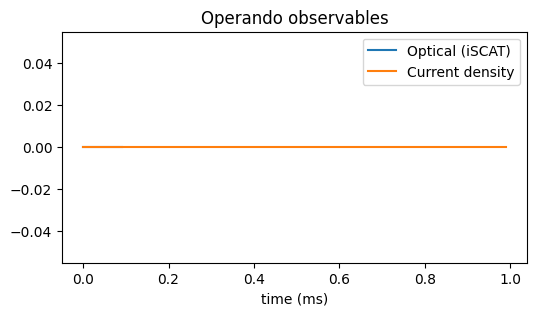

In [12]:
plt.figure(figsize=(6, 3))
plt.plot(np.array(step_result.times)*1e3, step_result.optical, label="Optical (iSCAT)")
plt.plot(np.array(step_result.times)*1e3, step_result.current_density, label="Current density")
plt.xlabel("time (ms)")
plt.legend()
plt.title("Operando observables")
plt.show()

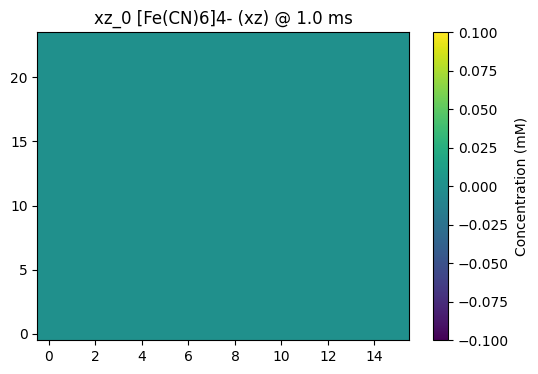

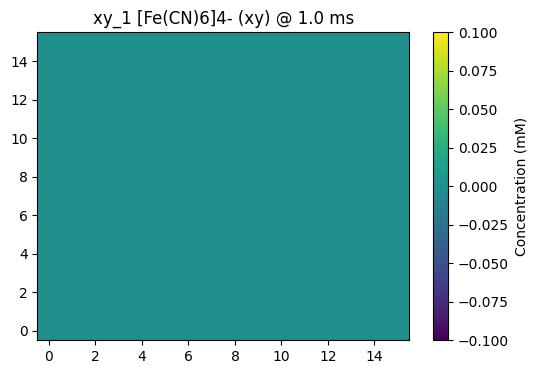

In [13]:
# 2D plane diagnostics
for key, frames in step_result.plane_data.items():
    latest = np.array(frames[-1])
    fig = plot_plane_field(latest, key.split('_')[0], name=f"{key} [Fe(CN)6]4-", time=step_result.times[-1])
    display(fig)
    plt.close(fig)

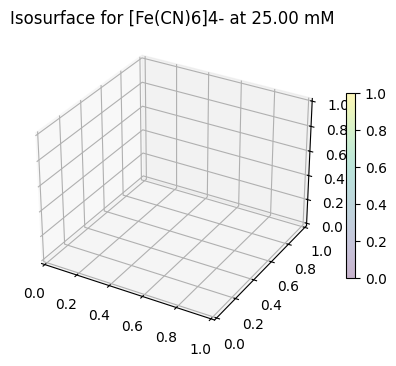

In [14]:
# 3D pseudo-isosurface of the reductant concentration
volume = np.array(sim.concentrations[0] * 1e6)
fig = plot_volume_isosurface(volume, iso_value=25.0, name='[Fe(CN)6]4-')
display(fig)
plt.close(fig)

## Cyclic voltammetry sweep
Here we switch to the same CV window as Figure S3 and demonstrate how to recover that slice.

In [8]:
sim.reset()
cv = CyclicVoltammogram(start=-0.2, lower=-0.2, upper=0.6, scan_rate=0.05, cycles=1)
cv_result = sim.run(cv)

Ion transport: 100%|██████████| 1000/1000 [00:01<00:00, 526.72it/s]


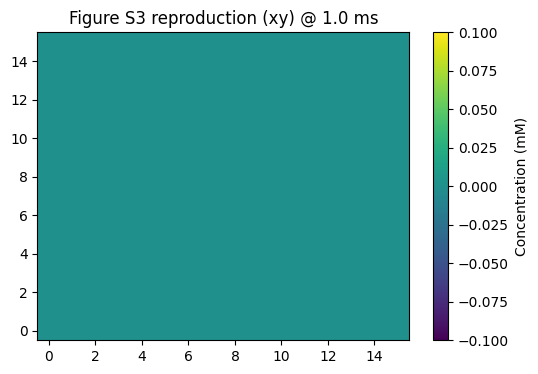

In [9]:
xy_key = [key for key in cv_result.plane_data if key.startswith('xy')][0]
xy_plane = np.array(cv_result.plane_data[xy_key][-1])
fig = plot_plane_field(xy_plane, 'xy', name='Figure S3 reproduction', time=cv_result.times[-1])
display(fig)
plt.close(fig)